# Training a dense neural network for MNIST

In [1]:
import torchvision
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import utils
train_loader, test_loader, train_set, test_set = utils.load_mnist(64)

## Fully connected dense neural networks

A basic NN consists of a no of layers. The simplest network would include just one-fully connected layer which is called Linear layer with 784 inputs and 10 outputs.
![](https://docs.microsoft.com/en-us/learn/modules/intro-computer-vision-pytorch/images/dense-onelayer-network.png)

The dimension of our digit images is 1 x 28 x 28. Because the imput dimension of a fully connected layer is 784, we need to insert another layer into the network called Flatten to change tensor shape from 1 x 28 x 28 to 784

We want n'th output of the network to return the probabilty of the input digit being equal to n. Because the output of a fully connected layer is not normalized to be between 0 and 1, it cannot be thought of as probability. To turn it into a probability we need to apply another layer called Softmax.

Architecture of out network can be represented by the following sequence of layers:
![](https://docs.microsoft.com/en-us/learn/modules/intro-computer-vision-pytorch/images/onelayer-network-layers.png)

In [2]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),
    nn.LogSoftmax(1)
)
net

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): LogSoftmax(dim=1)
)

# Training the network
A network defined this way can take any digit as input and produce a vector of probabilities as an output.

In [3]:
print('Digit to be predicted: ',train_set[0][1])
torch.exp(net(train_set[0][0]))

Digit to be predicted:  5


tensor([[0.1023, 0.0863, 0.0934, 0.1164, 0.0874, 0.0886, 0.0891, 0.1376, 0.1068,
         0.0921]], grad_fn=<ExpBackward0>)

The training process steps are as follows:

1. We take a minibatch from the input dataset, which consists of input data (features) and expected result (label).
2. We calculate the predicted result for this minibatch. 
3. The difference between this result and expected result is calculated using a special function called the **loss function**
4. We calculate the gradients of this loss function with respect to model weights (parameters), which are then used to adjust the weights to optimize the performance of the network. The amount of adjustment is controlled by a parameter called **learning rate**, and the details of optimization algorithm are defined in the **optimizer** object.
5. We repeat those steps until the whole dataset is processed. One complete pass through the dataset is called **an epoch**. 

Here is a function that performs one epoch training: 

In [4]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net,train_loader)

(0.00563592529296875, 0.897)

Since this function is pretty generic we will be able to use it later in our other examples. The function takes the following parameters:
* **Neural network**
* **DataLoader**, which defines the data to train on
* **Loss Function**, which is a function that measures the difference between the expected result and the one produced by the network. In most of the classification tasks `NLLLoss` is used, so we will make it a default.
* **Optimizer**, which defined an *optimization algorithm*. The most traditional algorithm is *stochastic gradient descent*, but we will use a more advanced version called **Adam** by default.
* **Learning rate** defines the speed at which the network learns. During learning, we show the same data multiple times, and each time weights are adjusted. If the learning rate is too high, new values will overwrite the knowledge from the old ones, and the network would perform badly. If the learning rate is too small it results in a very slow learning process. 

Here is what we do when training:
* Switch the network to training mode (`net.train()`)
* Go over all batches in the dataset, and for each batch do the following:
   - compute predictions made by the network on this batch (`out`)
   - compute `loss`, which is the discrepancy between predicted and expected values
   - try to minimize the loss by adjusting weights of the network (`optimizer.step()`)
   - compute the number of correctly predicted cases (**accuracy**)

The function calculates and returns the average loss per data item, and training accuracy (percentage of cases guessed correctly). By observing this loss during training we can see whether the network is improving and learning from the data provided.

It is also important to control the accuracy on the test dataset (also called **validation accuracy**). A good neural network with a lot of parameters can predict with decent accuracy on any training dataset, but it may poorly generalize to other data. That's why in most cases we set aside part of our data, and then periodically check how well the model performs on them. Here is the function to evaluate the network on test dataset:


In [5]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

(0.005201477432250977, 0.9102)

We train the model for several epochs observing training and validation accuracy. If training accuracy increases while validation accuracy decreases that would be an indication of overfitting. 
Below is the training function that can be used to perform both training and validation. It prints the training and validation accuracy for each epoch, and also returns the history that can be used to plot the loss and accuracy on the graph.



In [6]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax(1))

hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.899, Val acc=0.920, Train loss=0.006, Val loss=0.005
Epoch  1, Train acc=0.914, Val acc=0.899, Train loss=0.005, Val loss=0.005
Epoch  2, Train acc=0.917, Val acc=0.921, Train loss=0.005, Val loss=0.005
Epoch  3, Train acc=0.919, Val acc=0.921, Train loss=0.005, Val loss=0.005
Epoch  4, Train acc=0.921, Val acc=0.913, Train loss=0.005, Val loss=0.005


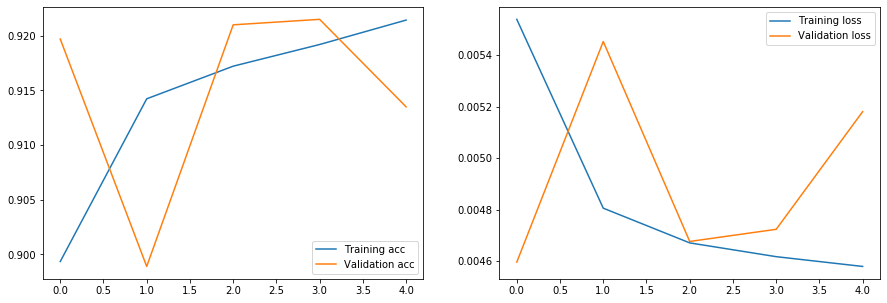

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()


# Visualizing network weights


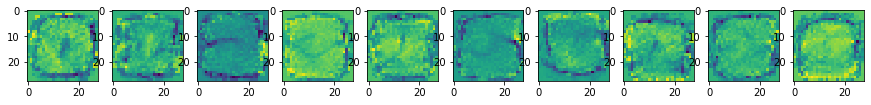

In [8]:
weight_tensor = next(net.parameters())
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).detach())